In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sqlite3
import gzip
import numpy as np
import pandas as pd
from src.tables_old import MapTable, df_to_tmp_table, df_to_table, get_machines, get_offers, get_tables, get_tbl_info, table_to_df, get_tbl_timespan
from src.preprocess import preprocess
from src.utils import  time_utc_now, np_min_chunk, df_na_vals, reduce_mem_usage
import seaborn as sns
import matplotlib.pyplot as plt
import logging

import warnings

# Filter out all warnings related to pandas
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
from src.manager import DbManager

# dbm = DbManager('../data/vast.db')
dbm = DbManager('../vast.db')

dbm.connect()
ts = dbm.table_to_df('ts_idx').timestamp
dbm.close()

sec = pd.to_datetime(ts * 1e9).diff().dt.seconds
sec.describe()

# sec

count    160789.000000
mean         60.971932
std         336.392293
min           1.000000
25%          54.000000
50%          56.000000
75%          59.000000
max       84261.000000
Name: timestamp, dtype: float64

Mode: 55.0


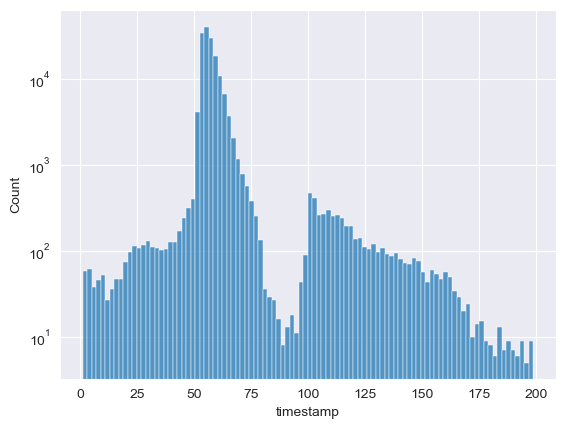

In [8]:
import seaborn as sns
print('Mode:', sec.mode()[0])
sns.histplot(sec[sec < 200], bins=100);
plt.yscale('log');

In [9]:
dbm.close()

In [8]:
import sqlite3
import os
import pandas as pd
from src.manager import DbManager

# db_path = '../data/vast.db'
db_path = '../vast.db'

dbm = DbManager(db_path)
dbm.connect()
timespan = dbm.get_tbl_timespan('ts_idx')
total_days = timespan.total_seconds() / (3600 * 24)

print('Timespan:', timespan)

# dbm.execute('VACUUM')
size = os.path.getsize(db_path) / (1024 * 1024) # Size in Mb

try:
    print(f'Size: {size: .2f} mb')
    print(f'Size per day: {size / total_days: .2f} mb')
    print(f'Size per year: {size / total_days * 365: .0f} mb')
except:
    pass

dbm.close()

Timespan: 197 days 04:44:18
Size:  846.79 mb
Size per day:  4.29 mb
Size per year:  1567 mb


In [6]:
dbm.connect()
df = dbm.get_db_stats()
dbm.close()
df

,name,pages,size,percentage
0,total,217798,850.77,100.00
1,reliability_ts,68675,268.26,31.53
2,idx_mach_ts_reliability,59813,233.64,27.46
3,avg_snp,21023,82.12,9.65
4,cost_ts,11510,44.96,5.28
5,idx_machine_ts_rent,9161,35.79,4.21
6,rent_ts,8926,34.87,4.10
7,disk_ts,7962,31.10,3.66
8,avg_ts,7606,29.71,3.49
9,idx_machine_ts_cost,6733,26.30,3.09


In [11]:
dbm.get_tbl_timespan('ts_idx')

Timedelta('168 days 03:28:47')

In [25]:
dbm.connect()
df = pd.read_sql('SELECT * FROM reliability_ts WHERE machine_id=12630', con=dbm.conn)
dbm.close()
df

,machine_id,reliability,timestamp
0,12630,9877,1705811014
1,12630,9878,1705877388
2,12630,9879,1705997407
3,12630,9880,1706008409
4,12630,9881,1706021668
...,...,...,...
190,12630,7021,1712222211
191,12630,8357,1712222372
192,12630,7021,1712222425
193,12630,8357,1712222533


In [45]:
# df.set_index(pd.to_datetime(df.timestamp * 1e9), inplace=True)
# df

In [86]:
machine_id = 8506
# machine_id = 12630

dbm.connect()
df1 = pd.read_sql(
    f'SELECT * FROM reliability_ts WHERE machine_id={machine_id}', con=dbm.conn,
    # index_col='timestamp'
)
df2 = pd.read_sql(
    f'SELECT * FROM rent_ts WHERE machine_id={machine_id}', con=dbm.conn,
    # index_col='timestamp'    
)
ts = pd.read_sql(
    'SELECT * FROM ts_idx', con=dbm.conn,
)

df3 = pd.read_sql(
    f'SELECT dph_base,timestamp,machine_id FROM cost_ts WHERE machine_id={machine_id}', con=dbm.conn,
    # index_col='timestamp'
)

df1.drop(columns=['machine_id'], inplace=True)
df2.drop(columns=['machine_id'], inplace=True)
df3.drop(columns=['machine_id'], inplace=True)

dbm.close()

df = pd.merge(ts, df1, how='left', on='timestamp').fillna(method='ffill')
df.dropna(subset=['reliability'], inplace=True)
df = pd.merge(df, df2, how='left', on='timestamp').fillna(method='ffill')
df = pd.merge(df, df3, how='left', on='timestamp').fillna(method='ffill')

df.reliability = df.reliability.astype('int')
df.num_gpus_rented = df.num_gpus_rented.astype('int')
df.dph_base = df.dph_base.astype('int')
df.drop_duplicates(subset=['reliability', 'num_gpus_rented', 'dph_base'], inplace=True)
df.timestamp = pd.to_datetime(df.timestamp, unit='s')
df

,timestamp,reliability,num_gpus_rented,dph_base
0,2023-10-19 07:04:30,9988,4,2200
7909,2023-10-24 08:00:40,9989,4,2200
13737,2023-10-28 02:24:51,9989,0,2200
26478,2023-11-05 09:58:10,9989,0,2400
26479,2023-11-05 09:59:06,9989,4,2400
...,...,...,...,...
58109,2023-11-26 09:51:59,9987,4,2000
58126,2023-11-26 10:07:28,9988,4,2000
58160,2023-11-26 10:39:41,9989,4,2000
66953,2023-12-11 11:12:44,9991,4,4000


In [75]:
df.timestamp = pd.to_datetime(df.timestamp, unit='s')
df

,timestamp,reliability,num_gpus_rented
0,2024-01-21 04:23:34,9877,0
1063,2024-01-21 22:49:48,9878,0
1985,2024-01-22 15:24:33,9878,1
2946,2024-01-23 08:10:07,9879,1
3000,2024-01-23 09:09:11,9879,0
...,...,...,...
52100,2024-04-04 06:12:47,7050,1
52168,2024-04-04 07:18:22,7032,1
52228,2024-04-04 08:18:32,7021,1
52286,2024-04-04 09:13:03,8357,1


In [83]:
dbm.close()

<Axes: xlabel='timestamp', ylabel='reliability'>

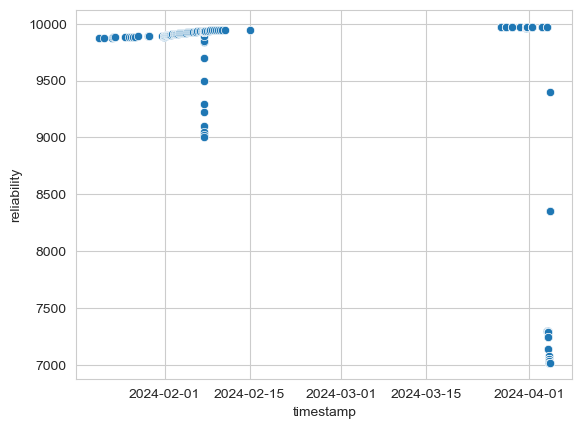

In [30]:
sns.scatterplot(df.reliability)

In [83]:
df.groupby('machine_id')['disk_bw'].resample('1D').mean().round().astype(np.uint16).reset_index().to_sql('disk_bw_avg', conn, if_exists='replace', index=False)

KeyError: 'machine_id'

In [41]:
df.groupby('machine_id')['disk_bw'].resample('1D').std().fillna(0).astype(np.uint16).reset_index().to_sql('disk_bw_std', conn, if_exists='replace', index=False)

4553

In [115]:
conn.close()

In [23]:
import sqlite3
import os
import numpy as np

DB_PATH = '../data'

# Create directories for databases if they don't exist
if not os.path.exists(DB_PATH):
    os.makedirs(DB_PATH)

# Function to create and populate a database with the specified data type and range
def create_and_populate_db(db_name, data_type, value_range, size=100000):
    db_path = os.path.join(DB_PATH, db_name)

    conn = sqlite3.connect(db_path)

    conn.execute(f"CREATE TABLE data (value {data_type})")


    # Generate and insert values within the specified range
    values = None
    if 'INTEGER' in data_type:
        values = np.random.randint(*value_range, size=size, dtype=np.uint32)
    elif 'REAL' in data_type:
        values = np.random.uniform(*value_range, size=size).astype(np.float32)
    else:
        raise ValueError('Unknown type')        
        
    rows = [(value,) for value in values]
    
    
    try:
        # print(rows[:3])
        # conn.executemany("INSERT INTO data (value) VALUES (?)", rows)

        for value in values:
            conn.execute(f"INSERT INTO data (value) VALUES ({value})")

        conn.commit()  
        conn.execute("VACUUM")    
    
    except Exception as e:
        print(e)
    
    conn.close()

# delete exiting db's
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    os.remove(db_path)


# Create and populate the databases
create_and_populate_db('integer_db.sqlite', 'INTEGER', (0, 300))  
# create_and_populate_db('integer_non_null_db.sqlite', 'INTEGER NOT NULL', (0, 1000))
create_and_populate_db('real_db.sqlite', 'REAL', (0, 1))            
# create_and_populate_db('real_non_null_db.sqlite', 'REAL NOT NULL', (0, 1000))            
# Print database sizes
for db_name in [f for f in os.listdir(DB_PATH) if f.endswith('.sqlite')]:
    db_path = os.path.join(DB_PATH, db_name)
    db_size = os.path.getsize(db_path) / (1024)  # Size in KB
    print(f"Database '{db_name}' size: {db_size:.2f} KB")

Database 'integer_db.sqlite' size: 932.00 KB
Database 'real_db.sqlite' size: 1564.00 KB


In [48]:
import os
import psutil

In [49]:
# Getting loadover15 minutes
load1, load5, load15 = psutil.getloadavg()

cpu_usage = (load15/os.cpu_count()) * 100

print("The CPU usage is : ", load1)

The CPU usage is :  0.0
